Using device: cuda
Immagini nel test degradato: 500
Numero Classi: 100
Pesi del modello Task 1 caricati con successo.
Avvio inferenza su test degradato...

=== RISULTATI BASELINE (Task 2) ===
Accuratezza Globale: 0.7160 (71.60%)

Generazione grafico Matrice di Confusione...


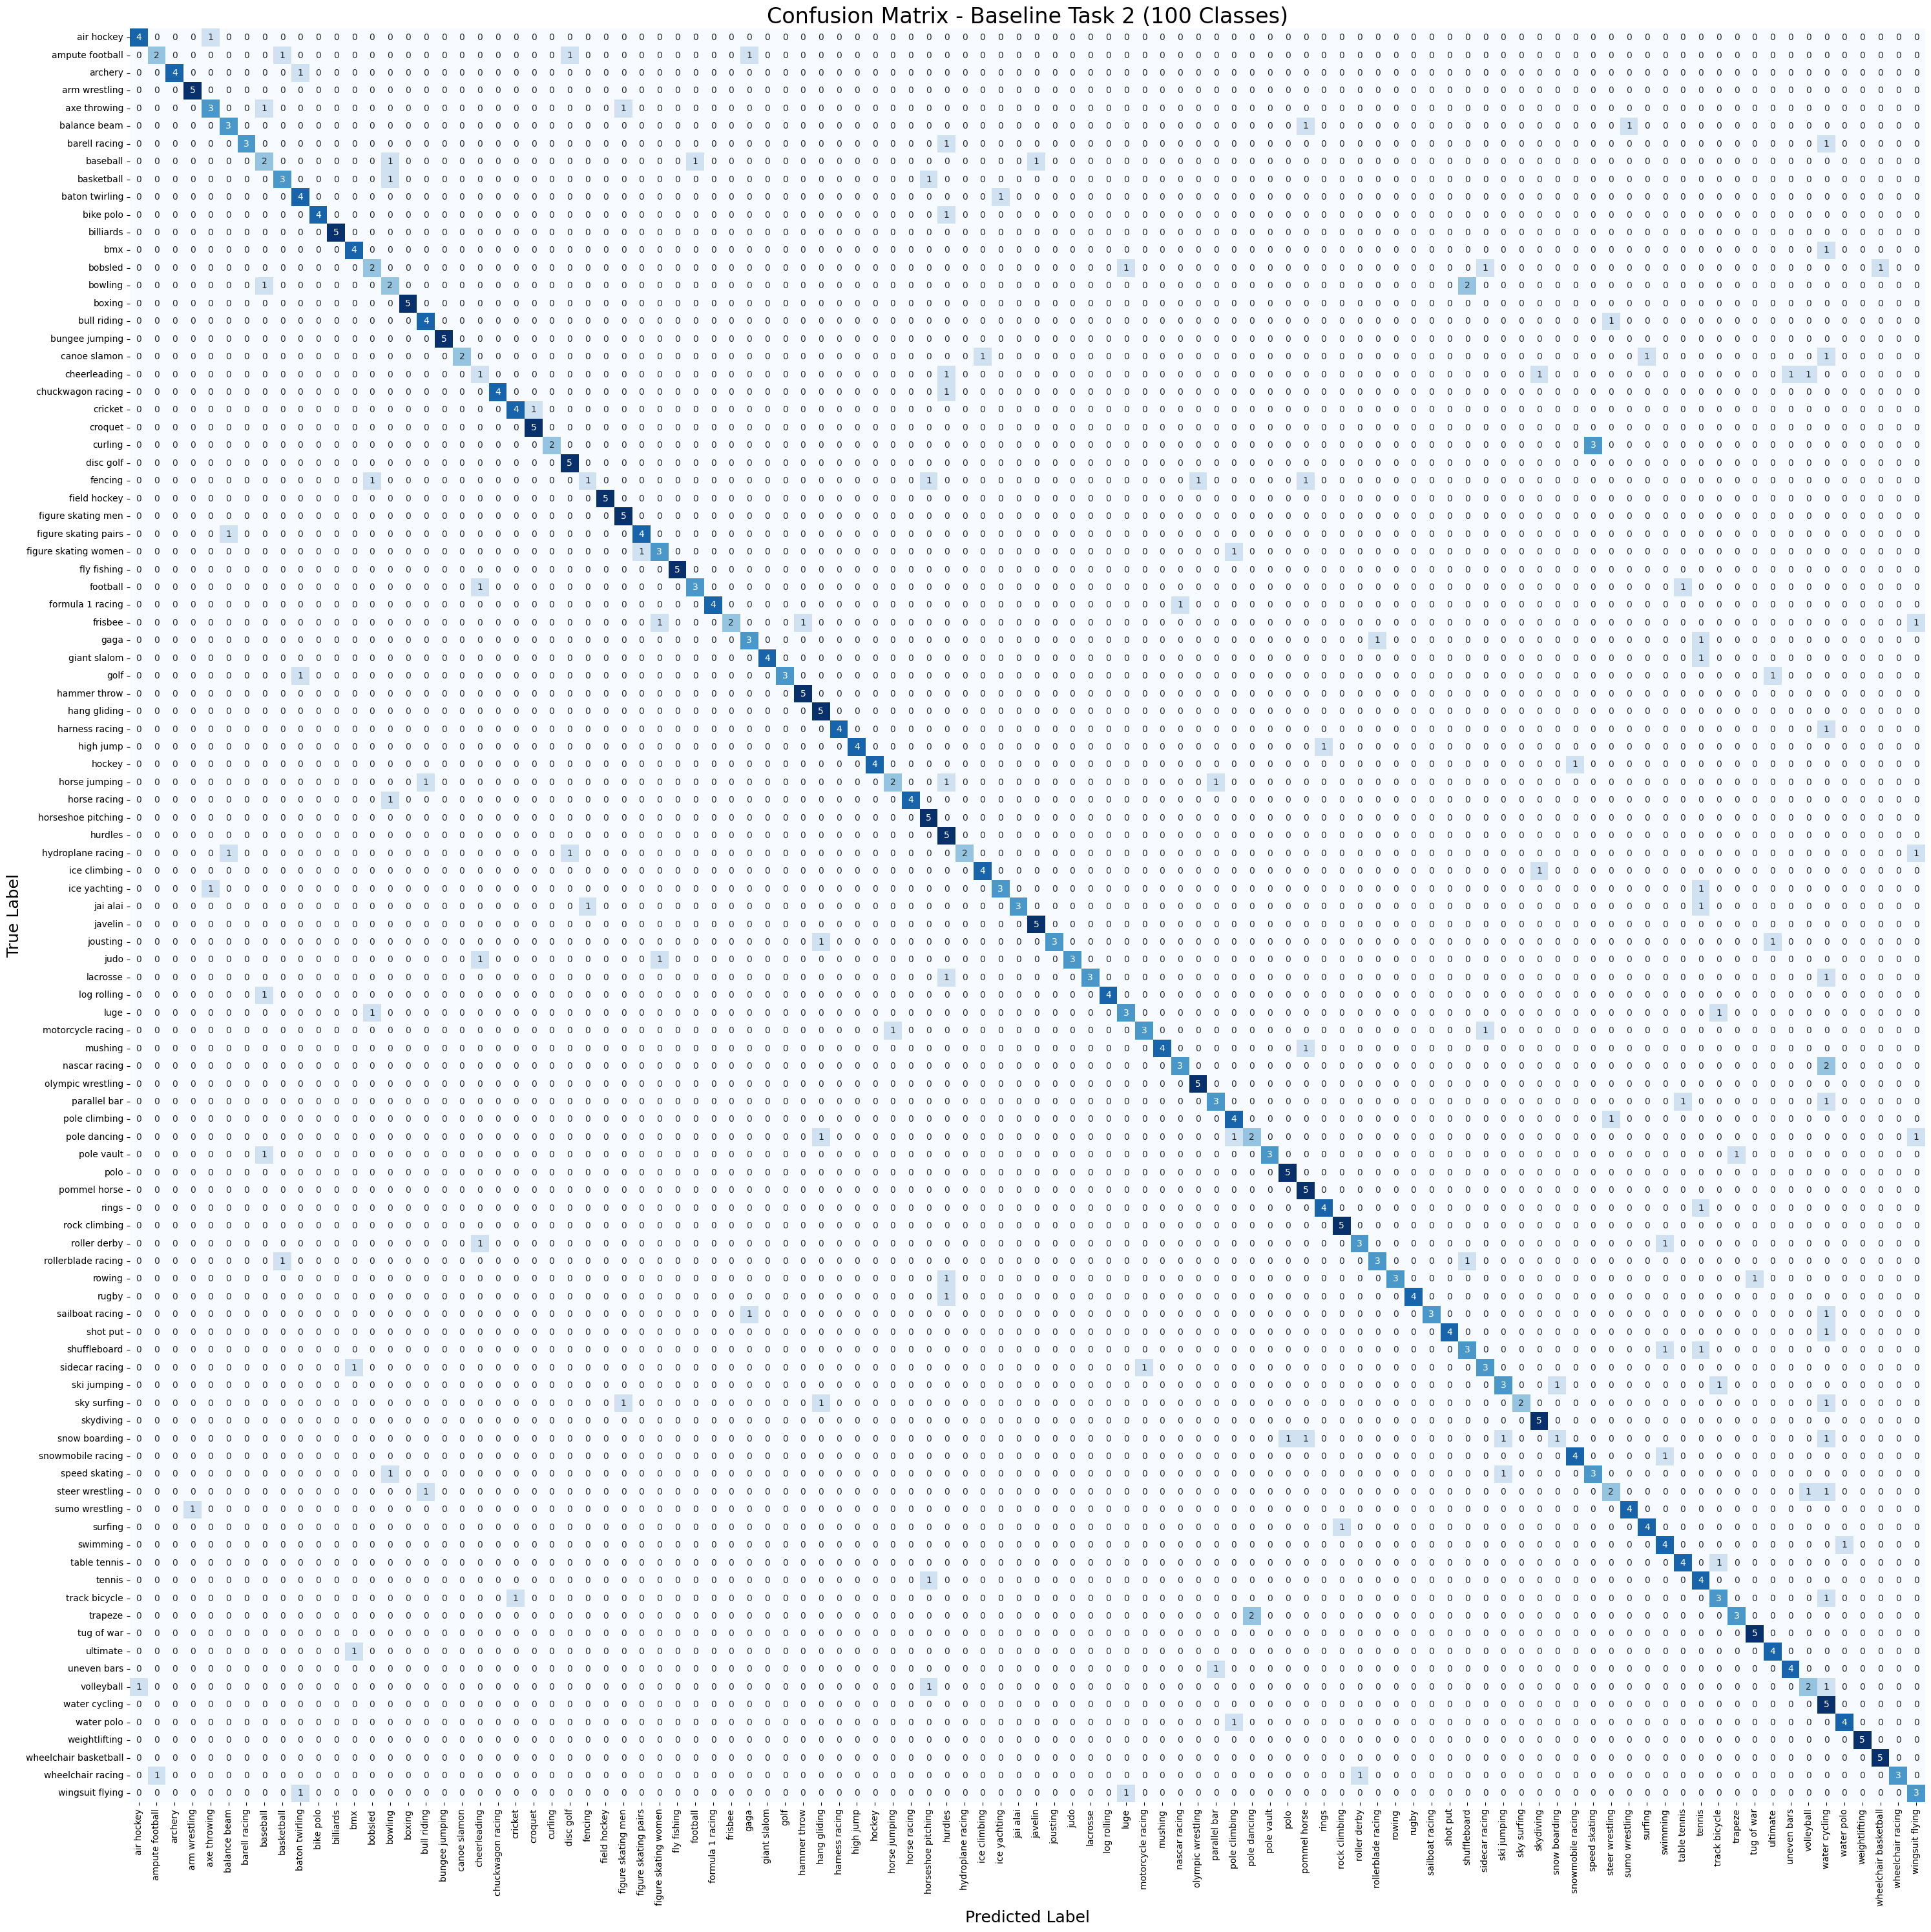

Matrice di confusione salvata come: confusion_matrix_baseline.png


In [5]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# ==========================================
# 1. CONFIGURAZIONE
# ==========================================
# Percorso alla cartella 'test_degradato' (Verifica che sia corretto nel tuo ambiente)
DEGRADED_TEST_DIR = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset-2/visual_dataset/test_degradato"
MODEL_PATH = "/kaggle/input/models/andreaspagnolo/resne18-task1/pytorch/default/1/best_model.pth"
BATCH_SIZE = 64
NUM_CLASSES = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# ==========================================
# 2. DEFINIZIONE MODELLO (Identico al Task 1)
# ==========================================
def build_resnet18(num_classes: int) -> nn.Module:
    # Usiamo weights=None perché carichiamo i nostri pesi custom
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ==========================================
# 3. TRASFORMAZIONI
# ==========================================
# Stesse trasformazioni usate per la validazione/test del Task 1
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

# ==========================================
# 4. FUNZIONE DI PLOT MATRICE DI CONFUSIONE
# ==========================================
def plot_confusion_matrix(cm, class_names, output_filename="confusion_matrix_baseline.png"):
    """
    Genera e salva una heatmap della matrice di confusione.
    """
    plt.figure(figsize=(30, 30))  # Dimensioni grandi per 100 classi
    sns.heatmap(
        cm, 
        annot=True,           # Scrive i numeri nelle celle
        fmt='d',              # Formato intero
        cmap='Blues',         # Colormap blu
        xticklabels=class_names, 
        yticklabels=class_names,
        cbar=False            # Rimuove la colorbar per risparmiare spazio laterale
    )
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.title(f'Confusion Matrix - Baseline Task 2 ({len(class_names)} Classes)', fontsize=24)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=150)
    plt.show()
    print(f"Matrice di confusione salvata come: {output_filename}")

# ==========================================
# 5. PIPELINE DI VALUTAZIONE
# ==========================================
def run_baseline_with_cm():
    if not os.path.exists(DEGRADED_TEST_DIR):
        print(f"[ERRORE] Non trovo la cartella: {DEGRADED_TEST_DIR}")
        return

    # Dataset e DataLoader
    degraded_dataset = datasets.ImageFolder(DEGRADED_TEST_DIR, transform=test_transforms)
    degraded_loader = DataLoader(
        degraded_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    class_names = degraded_dataset.classes
    print(f"Immagini nel test degradato: {len(degraded_dataset)}")
    print(f"Numero Classi: {len(class_names)}")

    # Caricamento Modello
    model = build_resnet18(NUM_CLASSES)
    
    try:
        # Carica i pesi
        state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(state_dict)
        print("Pesi del modello Task 1 caricati con successo.")
    except Exception as e:
        print(f"[ERRORE] Impossibile caricare i pesi: {e}")
        return

    model.to(DEVICE)
    model.eval()

    # Liste per salvare predizioni e target
    all_preds = []
    all_targets = []

    print("Avvio inferenza su test degradato...")
    
    with torch.no_grad():
        for inputs, labels in degraded_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calcolo Metriche
    acc = accuracy_score(all_targets, all_preds)
    print(f"\n=== RISULTATI BASELINE (Task 2) ===")
    print(f"Accuratezza Globale: {acc:.4f} ({acc*100:.2f}%)")
    
    # Calcolo Matrice di Confusione
    cm = confusion_matrix(all_targets, all_preds)
    
    # Visualizzazione
    print("\nGenerazione grafico Matrice di Confusione...")
    plot_confusion_matrix(cm, class_names)

# Esegui la baseline
if __name__ == "__main__":
    run_baseline_with_cm()